# Convolutional Neural Networks (LeNet)

In [1]:
import d2l
from mxnet import autograd, gluon, init, np, npx
from mxnet.gluon import nn
npx.set_np()

train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=256)

The model

In [2]:
net = nn.Sequential()
net.add(nn.Conv2D(channels=6, kernel_size=5, padding=2, activation='sigmoid'),
        nn.AvgPool2D(pool_size=2, strides=2),
        nn.Conv2D(channels=16, kernel_size=5, activation='sigmoid'),
        nn.AvgPool2D(pool_size=2, strides=2),
        nn.Dense(120, activation='sigmoid'),
        nn.Dense(84, activation='sigmoid'),
        nn.Dense(10))

Printing the output shape at each layer
to make sure we understand what's happening here.

In [3]:
X = np.random.uniform(size=(1, 1, 28, 28))
net.initialize()
for layer in net:
    X = layer(X)
    print(layer.name, 'output shape:\t', X.shape)

conv0 output shape:	 (1, 6, 28, 28)
pool0 output shape:	 (1, 6, 14, 14)
conv1 output shape:	 (1, 16, 10, 10)
pool1 output shape:	 (1, 16, 5, 5)
dense0 output shape:	 (1, 120)
dense1 output shape:	 (1, 84)
dense2 output shape:	 (1, 10)


Evaluate accuracy on GPU.

In [4]:
def evaluate_accuracy_gpu(net, data_iter, ctx=None):
    if not ctx:  # Query the first device the first parameter is on.
        ctx = list(net.collect_params().values())[0].list_ctx()[0]
    metric = d2l.Accumulator(2)  # num_corrected_examples, num_examples
    for X, y in data_iter:
        X, y = X.as_in_context(ctx), y.as_in_context(ctx)
        metric.add(d2l.accuracy(net(X), y), y.size)
    return metric[0]/metric[1]

The training function on GPU.

In [5]:
def train_ch5(net, train_iter, test_iter, num_epochs, lr, ctx=d2l.try_gpu()):
    net.initialize(force_reinit=True, ctx=ctx, init=init.Xavier())
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    trainer = gluon.Trainer(net.collect_params(),
                            'sgd', {'learning_rate': lr})
    animator = d2l.Animator(xlabel='epoch', xlim=[0,num_epochs],
                            legend=['train loss','train acc','test acc'])
    timer = d2l.Timer()
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)  # train_loss, train_acc, num_examples
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            # Here is the only difference compared to train_epoch_ch3
            X, y = X.as_in_context(ctx), y.as_in_context(ctx)
            with autograd.record():
                y_hat = net(X)
                l = loss(y_hat, y)
            l.backward()
            trainer.step(X.shape[0])
            metric.add(l.sum(), d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_loss, train_acc = metric[0]/metric[2], metric[1]/metric[2]
            if (i+1) % 50 == 0:
                animator.add(epoch + i/len(train_iter),
                             (train_loss, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch+1, (None, None, test_acc))
    print('loss %.3f, train acc %.3f, test acc %.3f' % (
        train_loss, train_acc, test_acc))
    print('%.1f exampes/sec on %s'%(metric[2]*num_epochs/timer.sum(), ctx))

Now let's train the model.

loss 0.475, train acc 0.820, test acc 0.784
44320.3 exampes/sec on gpu(0)


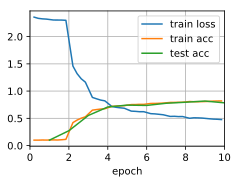

In [6]:
train_ch5(net, train_iter, test_iter, num_epochs=10, lr=0.9)